## Aaron Dharna
### Assignment 1

In [1]:
'''
###############################################################################################
    10-Armed Testbed (Reinforcement Learning: An Introduction, Sutton, Barto, fig 2.2)
    Created by Jet-Tsyn Lee 23/02/18, last update 03/01/18
    Program is to compare the greedy and e-greedy methods in a 10-armed bandit testbed, presented
    in the Reinforcement Learning: An Introduction book, Sutton, Barto, fig 2.2.
###############################################################################################
'''

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
################################################################
# TestBed class containing the states and actions, and the overall rules of the test
class Testbed(object):

    # Constructor
    def __init__(self, nArms, mean, stDev):

        # Number of arms
        self.nArms = nArms

        # Used for the Gaussian random actions
        self.mean = mean        # Mean
        self.stDev = stDev      # Standard Deviation

        self.actArr = np.zeros(nArms)   # Array to store action values
        self.optim = 0                  # Store optimal value for greedy

        #new random starting values.
        #self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)
        #self.optim = np.argmax(self.actArr)

        self.reset()

    # Reset testbed for next iteration
    def reset(self):
        # Set random gaussian/normal values using numpy function, requires mean, standard deviation and number of arms
        self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)

        # Identify the maximum value in action array
        self.optim = np.argmax(self.actArr)

In [3]:
################################################################
# Agent Class - Controls the agents movement and behaviour in the environment interacting with the testbed
# and receives information on the current position
class Agent(object):

    # Constructor
    def __init__(self,nArms, eProb=0, initial=0, C=None, stepSize=0.1, gradient=False, biased=True):

        self.nArms = nArms                          # Number of arms
        self.eProb = eProb                          # Epsilon probability
        self.initial = initial                      # Initial value estimation

        self.timeStep = 0                               # Time Step t
        self.lastAction = None                          # Store last action

        self.UCB_C = C                                  # UpperConfBound param


        self.stepSize = stepSize                        # StepSize of alpha
        self.biased = biased                            #flag to use biased stepsizes


        self.O = 0#np.zeros(nArms)                         #for unbiasedStep size calculations

        self.gradient = gradient                        #use the gradient?
        self.indicies = np.arange(nArms)                #index array
        self.avg_reward = 0                             #storage of avg_reward so it can be remembered

        self.kAction = np.zeros(nArms)                  # count of actions taken at time t
        self.rSum = np.zeros(nArms)                     # Sums number of rewards
        self.valEstimates = np.zeros(nArms) + initial   # action value estimates sum(rewards)/Amount


    # Return string for graph legend
    def __str__(self):
        if self.eProb == 0 and self.UCB_C is None and self.gradient == False:
            return "Greedy; init = {}; step = {}".format(self.initial, 
                                                         self.stepSize if self.biased else "unbiased")
        elif self.UCB_C is not None:
            return "UCB; C = {}; step = {}".format(self.UCB_C,
                                                  self.stepSize if self.biased else "unbiased")
        elif self.gradient == True:
            return "init = {}; step = {}; {}".format(self.initial, 
                                                    self.stepSize if self.biased else "unbiased",
                                                    "gradientBandit")
        else:
            return "Eps = {}; init = {}; step = {}".format(self.eProb, 
                                                           self.initial, 
                                                           self.stepSize if self.biased else "unbiased")


    # Selects action based on a epsilon-greedy behaviour,
    # if epsilon equals zero, then the agent performs a greedy selection
    def action(self):

        ### POLICY ###
        # Epsilon method
        randProb = np.random.random()   # Pick random probability between 0-1
        if randProb < self.eProb:
            a = np.random.choice(len(self.valEstimates))    # Select random action

        elif self.UCB_C is not None:

            #avoid 0/0 with time + 1 and kAction + delta
            UCB_estimation = self.valEstimates + \
                             self.UCB_C * (np.sqrt(np.log(self.timeStep + 1) / (self.kAction + 1e-5)))

            #find the best action
            action_max = np.argmax(UCB_estimation)

            #if multiple actions are the best, chose randomly
            other_choices = []
            for action, q in enumerate(UCB_estimation):
                #this will contain action_max
                if q == UCB_estimation[action_max]:
                    other_choices.append(action)

            a = np.random.choice(other_choices)


        elif self.gradient:

            exp_estimation = np.exp(self.valEstimates)
            self.action_probability = exp_estimation / np.sum(exp_estimation)
            a = np.random.choice(self.indicies, p=self.action_probability)

        # Greedy Method
        else:
            maxAction = np.argmax(self.valEstimates)     # Find max value estimate
            # identify the corresponding action, as array containing only actions with max
            action = np.where(self.valEstimates == self.valEstimates[np.argmax(self.valEstimates)])[0]

            # If multiple actions contain the same value, randomly select an action
            if len(action) == 0:
                a = maxAction
            else:
                a = np.random.choice(action)

        # save last action in variable, and return result
        self.lastAction = a
        return a


    # Interpreter - updates the value extimates amounts based on the last action
    def interpreter(self, reward):

        # Increase time step
        self.timeStep += 1


        # Add 1 to the number of action taken in step
        At = self.lastAction

        self.kAction[At] += 1       # Add 1 to action selection
        self.rSum[At] += reward     # Add reward to sum array

        self.avg_reward = (self.timeStep - 1)/self.timeStep * self.avg_reward + reward/self.timeStep

        step = 0

        if self.biased:
            step = self.stepSize
        else:
            # self.O[At] += self.stepSize*(1 - self.O[At])
            # unbiasedStep = self.stepSize / self.O[At]

            self.O += self.stepSize*(1 - self.O)
            unbiasedStep = self.stepSize / self.O
            step = unbiasedStep

        # Calculate new action-value, sum(r)/ka
        #
        # This is from equation 2.1
        #self.valEstimates[At] = self.rSum[At]/self.kAction[At]

        #
        # New Estimates based on stepsizes.
        # This is biased.
        #self.valEstimates[At] += self.stepSize * (reward - self.valEstimates[At])

        if self.gradient:
            one_hot = np.zeros(self.nArms)
            one_hot[At] = 1

            baseline = self.avg_reward

            #For all actions that are not the ones we chose, we get 0 - small amount.
            # for the action we chose we instead get 1 - small amount.
            # therefore, it decrements the actions we didn't chose and increments the chosen action.
            self.valEstimates = self.valEstimates + \
                                step * (reward - baseline) * (one_hot - self.action_probability)
            #in the grey box on page 39 at the bottom. 

        else:

            self.valEstimates[At] += step * (reward - self.valEstimates[At])






    # Reset all variables for next iteration
    def reset(self):
        self.timeStep = 0                    # Time Step t
        self.lastAction = None               # Store last action

        self.kAction[:] = 0                  # count of actions taken at time t
        self.rSum[:] = 0
        self.valEstimates[:] = 0 + self.initial  # action value estimates Qt ~= Q*(a)
        self.O = 0
        self.avg_reward = 0

In [4]:
################################################################
# Environment class to control all objects (agent/Testbed)
class Environment(object):

    # Constructor
    def __init__(self, testbed, agents, plays, iterations):
        self.testbed = testbed
        self.agents = agents

        self.plays = plays
        self.iterations = iterations


    # Run Test
    def play(self):

        # Array to store the scores, number of plays X number of agents
        scoreArr = np.zeros((self.plays, len(self.agents)))
        # Array to maintain optimal count, Graph 2
        optimlArr = np.zeros((self.plays, len(self.agents)))

        # loop for number of iterations
        for iIter in range(self.iterations):

            # Print statement after every 100 iterations
            if (iIter%100) == 0:
                #print("Completed Iterations: ",iIter)
                None

            #Reset testbed and all agents
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()


            # Loop for number of plays
            for jPlays in range(self.plays):
                agtCnt = 0

                for kAgent in self.agents:
                    actionT =  kAgent.action()

                    # Reward - normal dist (Q*(at), variance = 1)
                    rewardT = np.random.normal(self.testbed.actArr[actionT], scale=1)

                    # Agent checks state
                    kAgent.interpreter(reward=rewardT)

                    # Add score in arrary, graph 1
                    scoreArr[jPlays,agtCnt] += rewardT

                    # check the optimal action, add optimal to array, graph 2
                    if actionT == self.testbed.optim:
                        optimlArr[jPlays,agtCnt] += 1

                    agtCnt += 1

        #return averages
        scoreAvg = scoreArr/self.iterations
        optimlAvg = optimlArr/self.iterations

        return scoreAvg, optimlAvg

In [5]:
## MAIN ##
def run_exp(agents):
    start_time = time.time()    #store time to monitor execution
    nArms = 10                  # n number of bandits
    iterations = 2500           # number of repeated iterations
    plays = 1000                # number of pplays per iteration
    mean = 0
    std = 1

    # Setup objects to contain infomration about the agents, testbed, and environment
    testbed = Testbed(nArms=nArms,mean=mean,stDev=std)

    environment = Environment(testbed=testbed,agents=agents,plays=plays,iterations=iterations)

    # Run Environment
    print("Running...")
    g1Scores, g2Optimal = environment.play()
    print("Execution time: %s seconds" % (time.time() - start_time))


    #Graph 1 - Averate rewards over all plays
    plt.title("10-Armed TestBed - Average Rewards")
    plt.suptitle("mean {}, std {}".format(mean, std))
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()

    #Graph 1 - optimal selections over all plays
    plt.title("10-Armed TestBed - % Optimal Action")
    plt.suptitle("mean {}, std {}".format(mean, std))
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()

In [10]:
def getAgents():

    nArms=10
    
    agents = []

    agents1 = [
        Agent(nArms=nArms, eProb=0),
        Agent(nArms=nArms, eProb=0.02),
        Agent(nArms=nArms, eProb=0.05),
        Agent(nArms=nArms, eProb=0.1),
        Agent(nArms=nArms, eProb=0.15)
    ]

    agents2 = [
        Agent(nArms=nArms, eProb=0.1, initial=0),
        Agent(nArms=nArms, eProb=0.1, initial=5),
        Agent(nArms=nArms, eProb=0.1, initial=10),
        Agent(nArms=nArms, eProb=0.2, initial=1),
        Agent(nArms=nArms, eProb=0.2, initial=5),
    ]

    agents3 = [
        Agent(nArms=nArms, C=2, biased=False),
        Agent(nArms=nArms, eProb=0.1, biased=False),
    ]

    agents4 = [
        Agent(nArms=nArms, eProb=0, biased=False),
        Agent(nArms=nArms, eProb=0.1, biased=False)
    ]

    agents5 = [
        Agent(nArms=nArms, stepSize=0.1, gradient=True, biased=False),
        Agent(nArms=nArms, stepSize=0.4, gradient=True, biased=False),
    ]
    
    agents.append(agents1)
    agents.append(agents2)
    agents.append(agents3)
    agents.append(agents4)
    agents.append(agents5)
    
    return agents

In [11]:
#agents = getAgents()

Running...
Execution time: 254.42121410369873 seconds


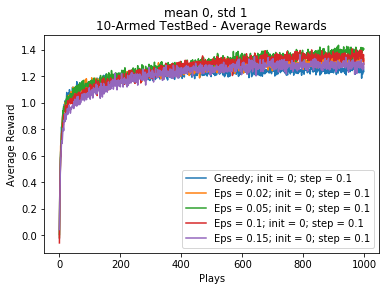

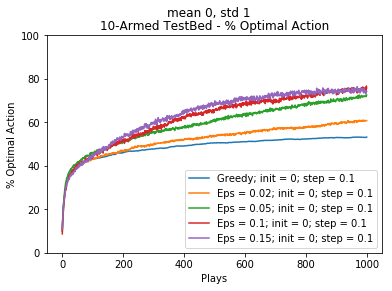

In [7]:
#run_exp(agents[0])

Here we see that in the `average reward` graph,over time, the average reward of each of our bandits is converging to ~1.4.  That being said, the greedy bandit has the lowest overall reward. Although the overlay makes comparison difficult here, the green bandit (ep = 0.05) seems to have the highest average reward overall. 

Furtheremore, in the `Optimal Actions` graph, the slope of the green bandit is greater than the other slopes. Therefore, the green bandit will, eventually converge to a steady-state higher than other bandits (except for the yellow bandit with epsilon of 0.02). However, the yellow bandit will take an extremely long time to overtake the green bandit. Therefore, for expediency of convergence, I posit that the green bandit is the best bandit for general use. 

----

Running...
Execution time: 267.8352687358856 seconds


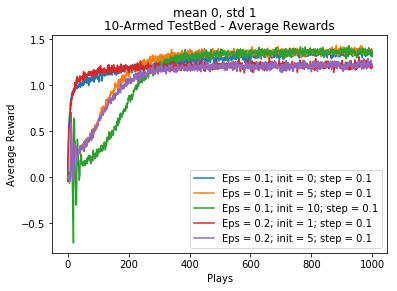

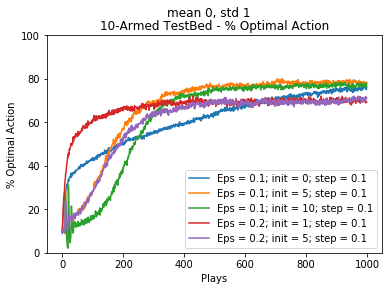

In [8]:
#run_exp(agents[1])

Here we are exploring the effects of varying both the epsilon parameter and the initialization paramater. 

i.e. optimistic initial search. 

In the `average rewards` and the `optimal actions` graph we see some interesting behaviour. 

Both of the bandits with the lowest initializations (blue and red) follow the same path -- high initial spike, but then quickly converge to a steady-state. The other three bandits (with varying epsilons and optimisms) oscilate at the early plays (indicating lots of variance in the actions chioce since as we explore options their value drops and we then chose a new actions to explore since the initial value is greater for unexplored actions). 

All three of the optimistic agents eventually converge to more optimal actions and greater reward because our step size in biased to remember the high initial values we gave. 

All that said, the green bandit which had the greatest optimism actually dropped value below zero since the true results were so greatly different from what it expected. this also caused an initial greater-than-the-others dip in the number of optimal actions taken at the state. 

----

Let us start here with defending my implementation of how I wrote the unbiased step size implementation:

According to the book we use a new variable `o` to decrease the weight of our step size with each new level pulled. In fact, `o` is defined recursively to be: 


### $$\bar{o}_n = \bar{o}_{n-1} + \alpha * (1 - \bar{o}_{n-1}), where: \bar{o}_0 = 0$$

### and $\beta_n$, our unbiased step size is: 

### $$\beta_n = \alpha / \bar{o}_n$$

Here, we see that $\bar{o}_n$ is alpha at the first time step, and will shrink over time. Therefore, $\beta_n$ will grow and we forget older timesteps sooner than $\lim_t (n) \rightarrow \infty$

Therefore, I interpreted $\bar{o}_n$ as a single value from $\mathbb{R}$ which got updated with each time we make a value update. 

----

Running...
Execution time: 156.19321727752686 seconds


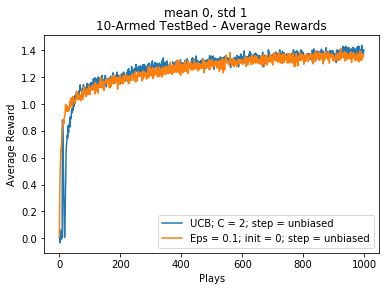

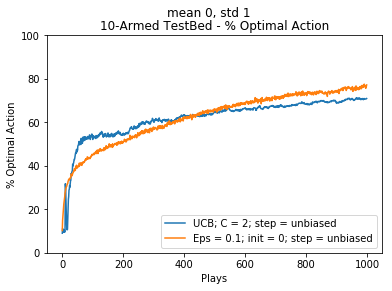

In [9]:
#run_exp(agents[2])

In the `average rewards` and the `optimal actions` graph we see some strange action from the Upper-Confidence-Bound action selection. 

We define the action we choose as: 

$$A_t := argmax_a[Q_t{(a)} + c\sqrt{\ln{(t)} / N_t{(a)}}]$$

We see that after an initial few steps of exploring ALL of the available actions since the $\sqrt{\ln{(t)} / N_t{(a)}}$ will cause us to increase the likelihood that we choose new actions. In fact, according to Sutton:

>The quantity being maxâ€™ed over is thus a sort of upper bound on the possible true value of action a, with c determining the confidence level. Each time a is selected the uncertainty is presumably reduced.

----

Running...
Execution time: 106.14221739768982 seconds


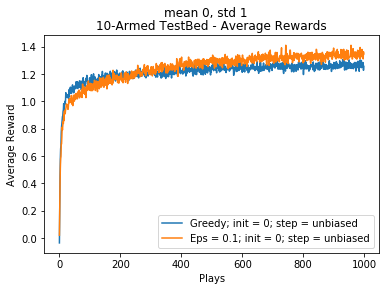

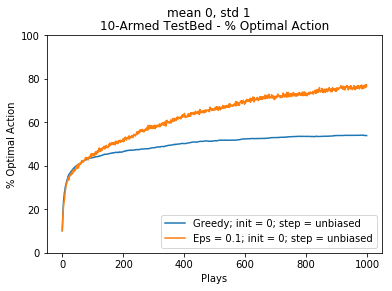

In [10]:
#run_exp(agents[3])

The experiments on agent 4 are simply showing what the initial set of agents (greedy, and $\epsilon - greedy$) update like when we instead use the unbiased step size. This behaves exactly as I would expect and the $\epsilon - greedy$ bandit overtakes the greedy one soon after initialization. 

----

In Exp5, the Blue bandit is $\alpha = 0.1$, while the Orange bandit is $\alpha = 0.4$

Running...
Execution time: 370.6987941265106 seconds


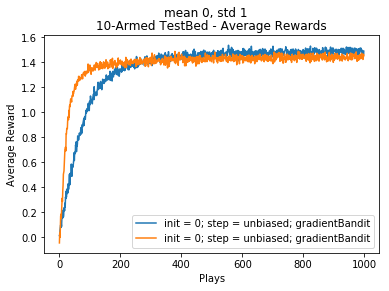

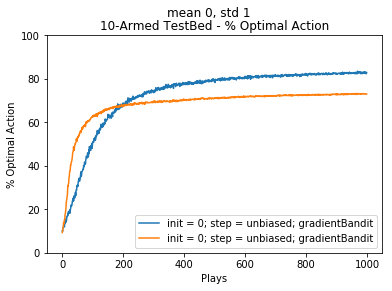

In [11]:
#run_exp(agents[4])

Finally, we implement and use the `gradient` bandit. 

We see something that makes sense here when we instead think of the gradient bandit as gradient ascent. Gradient ascent (and descent) both rely on having a step size that is small -- this allows us to use the derivative of a continuous function we are looking to optimize to find a space in the curve where the slope is zero. If we take steps that are too large, we can overshoot the local minima. This seems to be what is happening when $\alpha = 0.4$.

----

----

In [ ]:
if '__name__' == __main__:
    agents = getAgents()
    run_exp(agents[0])
    run_exp(agents[1])
    run_exp(agents[2])
    run_exp(agents[3])
    run_exp(agents[4])